In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

In [2]:
cols = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

In [5]:
df = pd.read_csv(
    r"C:\Users\ASUS\anaconda3\Predictive Maintenance\data\FD001\train_FD001.txt",
    sep=" ",
    header=None
)

df = df.iloc[:, :len(cols)]
df.columns = cols

In [6]:
df.shape
df.head()
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,29.227633,1.0000,26.0000,52.0,77.0000,100.0000
cycle,20631.0,108.807862,68.880990,1.0000,52.0000,104.0,156.0000,362.0000
op_setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0,0.0015,0.0087
op_setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000,100.0000,100.0000,100.0,100.0000,100.0000


In [7]:
df["engine_id"].nunique(), df["cycle"].max()

(100, 362)

In [8]:
sensor_cols = [c for c in df.columns if "sensor" in c]

df[sensor_cols].std().sort_values()

sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    1.556432e-14
sensor_10    4.660829e-13
sensor_5     3.394700e-12
sensor_1     6.537152e-11
sensor_6     1.388985e-03
sensor_15    3.750504e-02
sensor_8     7.098548e-02
sensor_13    7.191892e-02
sensor_21    1.082509e-01
sensor_20    1.807464e-01
sensor_11    2.670874e-01
sensor_2     5.000533e-01
sensor_12    7.375534e-01
sensor_7     8.850923e-01
sensor_17    1.548763e+00
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_14    1.907618e+01
sensor_9     2.208288e+01
dtype: float64

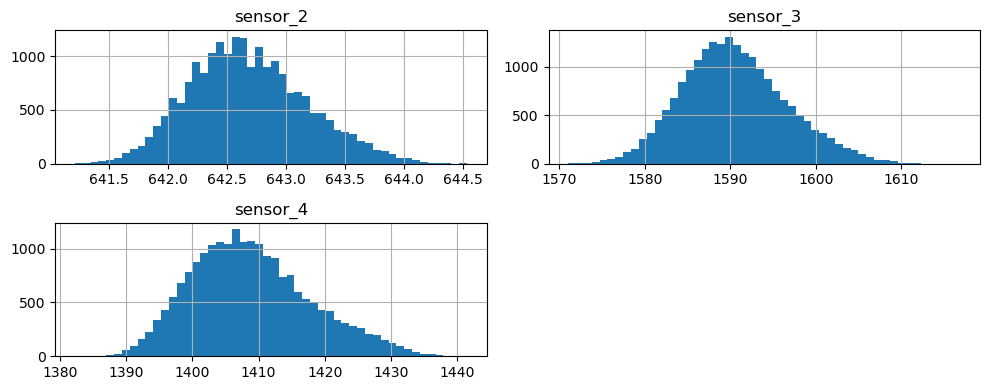

In [10]:
df[["sensor_2", "sensor_3", "sensor_4"]].hist(bins=50, figsize=(10,4))
plt.tight_layout()

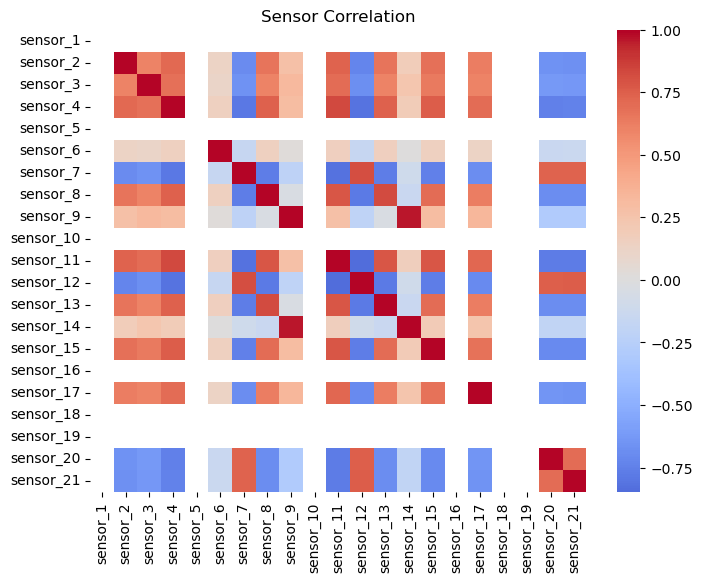

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[sensor_cols].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Sensor Correlation")
plt.show()

In [12]:
drop_sensors = [
    "sensor_1",
    "sensor_5",
    "sensor_6",
    "sensor_10",
    "sensor_16",
    "sensor_18",
    "sensor_19"
]

In [14]:
# EDA Observations
#- Multiple sensors exhibit near-zero variance and were excluded from downstream modeling.
#- Several sensor groups show strong correlation, motivating the use of tree-based models.
#- Sensor distributions appear approximately unimodal with clear degradation trends over time.

In [15]:
# max cycle per engine
max_cycle = df.groupby("engine_id")["cycle"].max()

# map RUL
df["RUL"] = df.apply(
    lambda row: max_cycle[row["engine_id"]] - row["cycle"],
    axis=1
)

In [16]:
FAILURE_THRESHOLD = 30

df["failure"] = (df["RUL"] <= FAILURE_THRESHOLD).astype(int)

In [17]:
df["failure"].value_counts(normalize=True)

failure
0    0.849741
1    0.150259
Name: proportion, dtype: float64

In [18]:
df_fe = df.drop(columns=[
    "RUL",
    *drop_sensors
])

In [19]:
roll_sensors = [
    "sensor_2", "sensor_3", "sensor_4",
    "sensor_7", "sensor_8", "sensor_9",
    "sensor_11", "sensor_12", "sensor_13",
    "sensor_14", "sensor_15", "sensor_17"
]

In [20]:
WINDOW = 10

df_fe = df_fe.sort_values(["engine_id", "cycle"])

for sensor in roll_sensors:
    df_fe[f"{sensor}_roll_mean"] = (
        df_fe.groupby("engine_id")[sensor]
        .rolling(WINDOW)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    df_fe[f"{sensor}_roll_std"] = (
        df_fe.groupby("engine_id")[sensor]
        .rolling(WINDOW)
        .std()
        .reset_index(level=0, drop=True)
    )

In [21]:
df_fe = df_fe.dropna()

In [22]:
X = df_fe.drop(columns=["engine_id", "cycle", "failure"])
y = df_fe["failure"]

In [23]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)

train_idx, test_idx = next(
    gss.split(X, y, groups=df_fe["engine_id"])
)

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
from sklearn.metrics import roc_auc_score

y_proba = lr.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test, y_proba)

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=20,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [32]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_proba_rf)

In [29]:
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(10)

sensor_15_roll_mean    0.128716
sensor_17_roll_mean    0.122487
sensor_3_roll_mean     0.090239
sensor_2_roll_mean     0.082483
sensor_7_roll_mean     0.077038
sensor_11_roll_mean    0.076070
sensor_4_roll_mean     0.065309
sensor_12_roll_mean    0.051018
sensor_12              0.038628
sensor_11              0.032324
dtype: float64

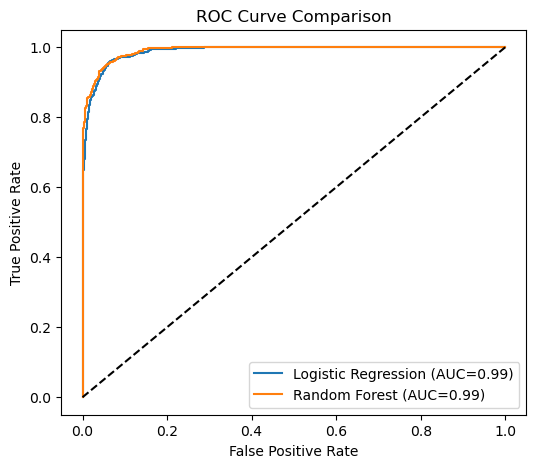

In [33]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={lr_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()